In [1]:
from setup_cc import *
from sklearn.preprocessing import StandardScaler
from hembedder.utils.hyperparameter_tuning_legacy import grid_search, random_search
from hembedder.utils import quality_metrics
from hembedder.utils.hyperparameter_tuning import Hyperparameter_tuning
import umap
from sklearn.decomposition import PCA
import pacmap
import trimap
#import phate
#n_n 5
evaluate_dcor_2_default = quality_metrics.CDEmbeddingPerformance(dcor_level=2, metric='manhattan')
ascending = [False,False, False, False,False]
evaluate = quality_metrics.CDEmbeddingPerformance(dcor_level=1,metric='manhattan', n_neighbours=15)
evaluators = {'Random_triplets' : evaluate.random_triplet_eval,
                    'dcor_1': evaluate._return_distance_correlation,
                    'neighbor_kept_ratio_15' : evaluate.neighbor_kept_ratio_eval,
                    'dcor_2': evaluate_dcor_2_default._return_distance_correlation,
                    'Trustworthiness': evaluate._return_trustworthiness}



## PCA comparison
### With scaler

In [2]:

pca_param = {'n_components': [2,4,6,8,10,20,30],
            "whiten": [False,True]}
tuning = Hyperparameter_tuning(cell_dyn,PCA,evaluators=evaluators,param_grid=pca_param,
                        ascending=ascending, file_name="models/embedding/PCA/cell_dyn_tuning_PCA_40000_MF100_n_components.csv",
                        sample_size=40000,metric_chuck_size=5000,standardised=True, num_iter=10, dtype=np.float32,
                        n_parjobs=10)
results = tuning.grid_search()

tuning.results.to_csv("models/embedding/PCA/cell_dyn_tuning_PCA_40000_MF100_n_components.csv")



Total number of embedding runs :  14 (combos)x10(iterations) with [40000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


14it [1:55:40, 495.77s/it]                        

Hyperpameter tuning is done and the best scores with 40000 sample size are
Random_triplets            0.97638
dcor_1                    0.998589
neighbor_kept_ratio_15    0.778704
dcor_2                    0.911893
Trustworthiness           0.997398
Name: 0, dtype: object
with parameter: {'n_components': 30, 'whiten': False}
Finish tuning in  115.68 minutes.


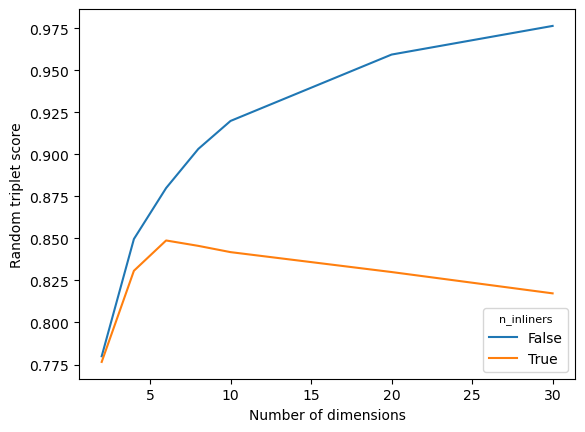

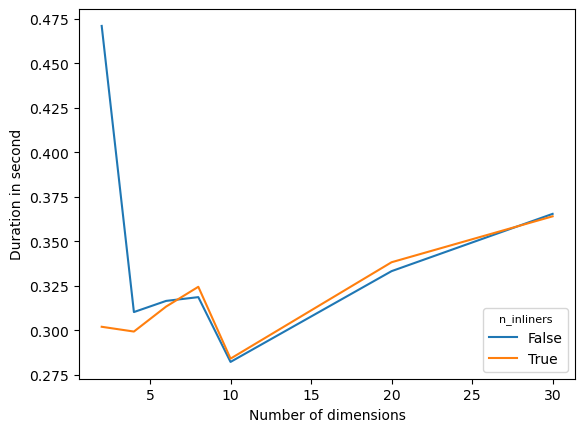

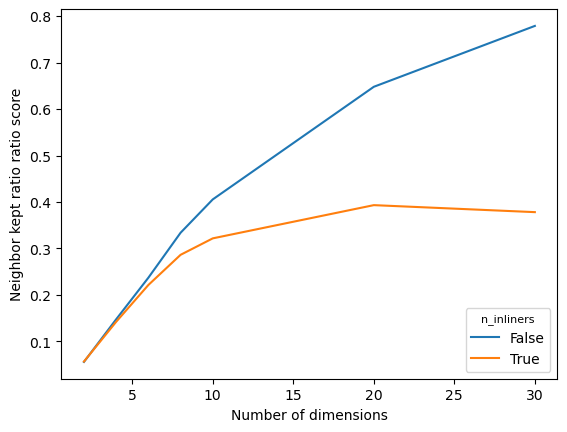

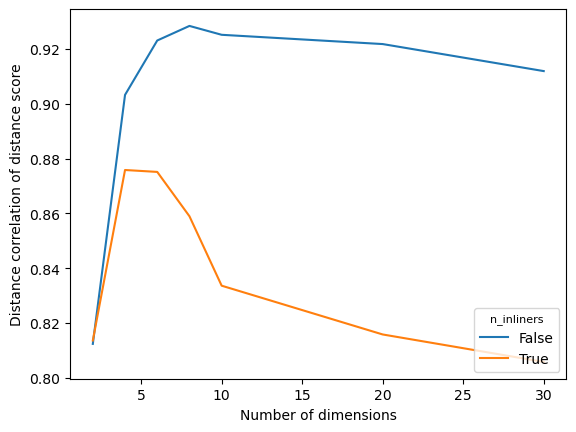

In [2]:
pca_data= pd.read_csv("models/embedding/PCA/cell_dyn_tuning_PCA_40000_MF100_n_components.csv")

performance_plot_same_file(pca_data,x="n_components",y="Random_triplets", hue="whiten",x_title="Number of dimensions",y_title="Random triplet score",legend_title="n_inliners")
performance_plot_same_file(pca_data,x="n_components",y="duration_in_second", hue="whiten",x_title="Number of dimensions",y_title="Duration in second",legend_title="n_inliners")
performance_plot_same_file(pca_data,x="n_components",y="neighbor_kept_ratio_15", hue="whiten",x_title="Number of dimensions",y_title="Neighbor kept ratio ratio score",legend_title="n_inliners")
performance_plot_same_file(pca_data,x="n_components",y="dcor_2", hue="whiten",x_title="Number of dimensions",y_title="Distance correlation of distance score",legend_title="n_inliners")

In [5]:
pca_embedding_scores = pd.read_csv("models/embedding/PCA/cell_dyn_tuning_PCA_40000_MF100_n_components.csv")

## PacMap

In [7]:
pacmap_param = {'n_components': [2,4,6,8,10,20,30]}
tuning = Hyperparameter_tuning(cell_dyn,pacmap.PaCMAP,evaluators=evaluators,param_grid=pacmap_param,
                        ascending=ascending, file_name="models/embedding/pacmap/cell_dyn_tuning_pacmap_40000_MF100_n_components.csv",
                        sample_size=40000,metric_chuck_size=5000,standardised=True, num_iter=10, dtype=np.float32,
                        n_parjobs=10)
results = tuning.grid_search()

tuning.results.to_csv("models/embedding/pacmap/cell_dyn_tuning_pacmap_40000_MF100_n_components.csv")

Total number of embedding runs :  7 (combos)x10(iterations) with [30000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


7it [1:47:22, 920.42s/it]                       

Hyperpameter tuning is done and the best scores with 30000 sample size are
Random_triplets           0.751532
dcor_1                    0.815474
neighbor_kept_ratio_30    0.119115
dcor_2                    0.677716
Trustworthiness            0.84922
Name: 0, dtype: object
with parameter: {'n_components': 2}
Finish tuning in  107.38 minutes.


## TriMap

In [2]:

trimap_param = {'n_dims': [2,4,6,8,10,20,30],
                'n_inliers' : [5,15,30,50,100]}
tuning = Hyperparameter_tuning(cell_dyn,trimap.TRIMAP,evaluators=evaluators,param_grid=trimap_param,
                        ascending=ascending, file_name="models/embedding/trimap/cell_dyn_tuning_trimap_40000_MF100_n_components_n_inliers.csv",
                        sample_size=40000,metric_chuck_size=5000,standardised=True, num_iter=10, dtype=np.float32,
                        n_parjobs=10, distance = 'manhattan')
results = tuning.grid_search()

tuning.results.to_csv("models/embedding/trimap/cell_dyn_tuning_trimap_40000_MF100_n_components_n_inliers.csv")

Total number of embedding runs :  35 (combos)x10(iterations) with [40000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


35it [30:25:09, 3128.85s/it]                           

Hyperpameter tuning is done and the best scores with 40000 sample size are
Random_triplets           0.782312
dcor_1                    0.900346
neighbor_kept_ratio_30    0.147319
dcor_2                    0.811135
Trustworthiness           0.960437
Name: 0, dtype: object
with parameter: {'n_dims': 6, 'n_inliers': 100, 'distance': 'manhattan'}
Finish tuning in  1825.16 minutes.


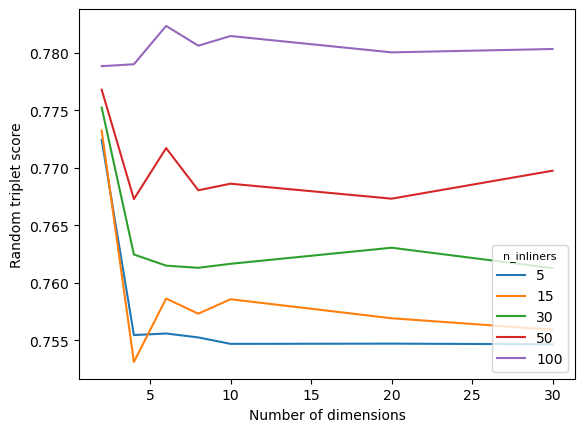

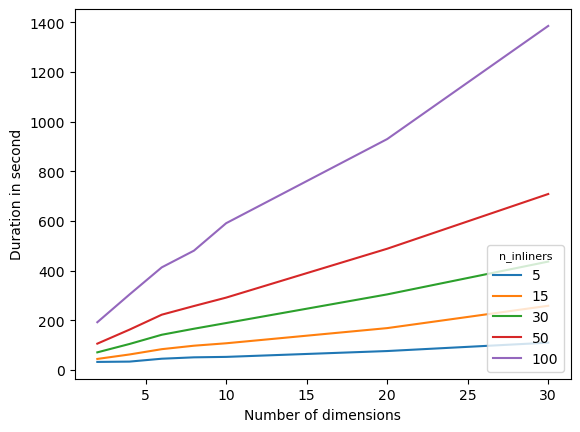

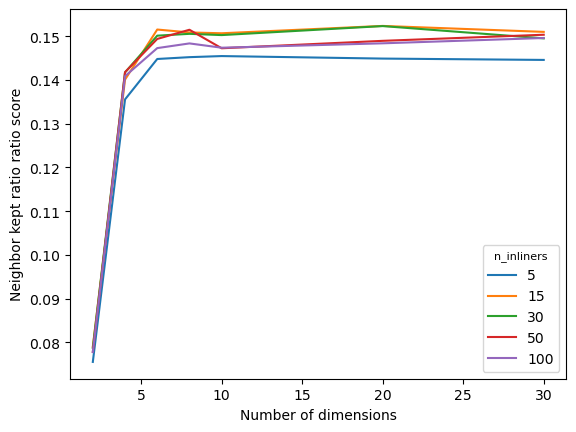

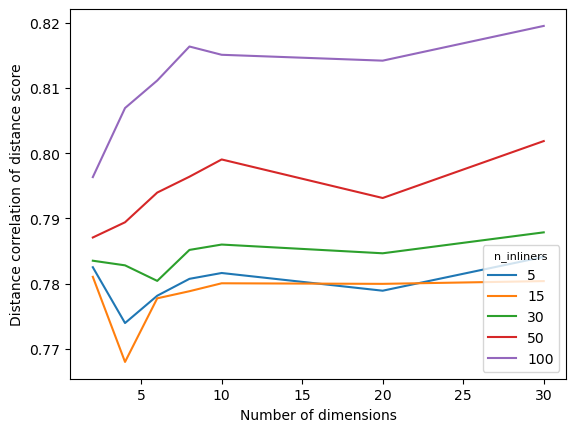

In [7]:
trimap_data= pd.read_csv("models/embedding/trimap/cell_dyn_tuning_trimap_40000_MF100_n_components_n_inliers.csv")
trimap_data['n_components'] = trimap_data['n_dims'].values
performance_plot_same_file(trimap_data,x="n_dims",y="Random_triplets", hue="n_inliers",x_title="Number of dimensions",y_title="Random triplet score",legend_title="n_inliners")
performance_plot_same_file(trimap_data,x="n_dims",y="duration_in_second", hue="n_inliers",x_title="Number of dimensions",y_title="Duration in second",legend_title="n_inliners")
performance_plot_same_file(trimap_data,x="n_dims",y="neighbor_kept_ratio_30", hue="n_inliers",x_title="Number of dimensions",y_title="Neighbor kept ratio ratio score",legend_title="n_inliners")
performance_plot_same_file(trimap_data,x="n_dims",y="dcor_2", hue="n_inliers",x_title="Number of dimensions",y_title="Distance correlation of distance score",legend_title="n_inliners")

## Gaussian random projection

In [2]:
from sklearn.random_projection import GaussianRandomProjection
GRP_param = {'n_components': [2,4,6,8,10,20,30],
                'eps' : [0.1,0.3,0.5,0.8,1.0]}
tuning = Hyperparameter_tuning(cell_dyn,GaussianRandomProjection,evaluators=evaluators,param_grid=GRP_param,
                        ascending=ascending, file_name="models/embedding/GaussianRandomProjection/cell_dyn_tuning_GaussianRandomProjection_40000_MF100_n_components_eps.csv",
                        sample_size=40000,metric_chuck_size=5000,standardised=True, num_iter=10, dtype=np.float32,
                        n_parjobs=10)
results = tuning.grid_search()

tuning.results.to_csv("models/embedding/GaussianRandomProjection/cell_dyn_tuning_GaussianRandomProjection_40000_MF100_n_components_eps.csv")

Total number of embedding runs :  35 (combos)x10(iterations) with [40000] sample_size for the embedding. Exceptions will be raised, if sample  size is larger than data size which is 3093792


35it [4:57:47, 510.50s/it]                          

Hyperpameter tuning is done and the best scores with 40000 sample size are
Random_triplets           0.865812
dcor_1                    0.930128
neighbor_kept_ratio_15    0.373699
dcor_2                    0.898098
Trustworthiness           0.976799
Name: 0, dtype: object
with parameter: {'n_components': 30, 'eps': 0.8}
Finish tuning in  297.79 minutes.


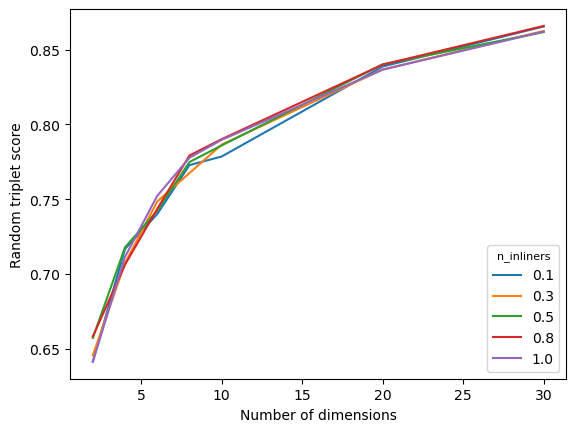

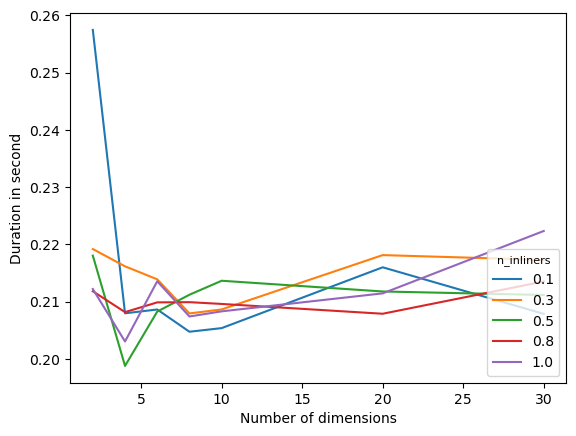

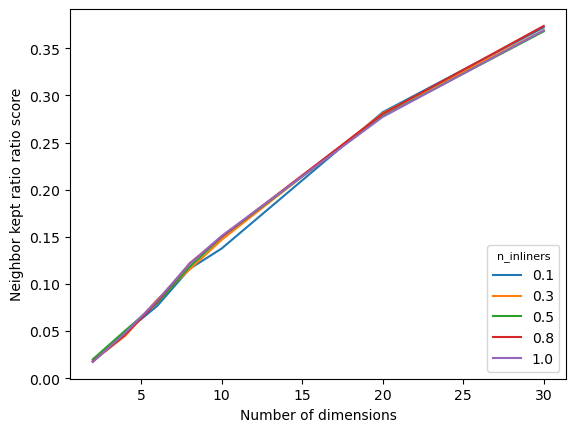

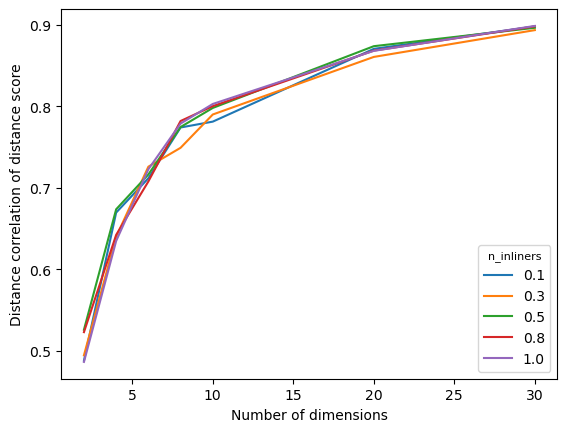

In [6]:
grp_data= pd.read_csv("models/embedding/GaussianRandomProjection/cell_dyn_tuning_GaussianRandomProjection_40000_MF100_n_components_eps.csv")

performance_plot_same_file(grp_data,x="n_components",y="Random_triplets", hue="eps",x_title="Number of dimensions",y_title="Random triplet score",legend_title="n_inliners")
performance_plot_same_file(grp_data,x="n_components",y="duration_in_second", hue="eps",x_title="Number of dimensions",y_title="Duration in second",legend_title="n_inliners")
performance_plot_same_file(grp_data,x="n_components",y="neighbor_kept_ratio_15", hue="eps",x_title="Number of dimensions",y_title="Neighbor kept ratio ratio score",legend_title="n_inliners")
performance_plot_same_file(grp_data,x="n_components",y="dcor_2", hue="eps",x_title="Number of dimensions",y_title="Distance correlation of distance score",legend_title="n_inliners")

## Comparing different embedders on different different dimensions

In [ ]:
umap_data = pd.read_csv("models/embedding/UMAP/cell_dyn_UMAP_tune_MF100_sizes_large_n_n_15_std.csv")
embedder_list = [ pca_embedding_scores[pca_embedding_scores["whiten"]==False],umap_data,trimap_data[trimap_data["n_inliers"]==100],grp_data[grp_data["eps"] == 0.1]]
hue = ['PCA','UMAP','TriMap', 'Gaussian Random Projection']
performance_plot_different_files(embedder_list,'n_components','Random_triplets', 'Sample size',"Random triplet score",hue, "Nearest Neighbours")
performance_plot_different_files(embedder_list,'n_components','duration_in_second', 'Sample size','Duration in second',hue, "Nearest Neighbours")
performance_plot_different_files(embedder_list,'n_components','neighbor_kept_15', 'Sample size','Neighbourhood kept ratio (default setting) score',hue, "Nearest Neighbours")
performance_plot_different_files(embedder_list,'n_components','dcor_2', 'Sample size','Distance correlation score',hue, "Nearest Neighbours")
performance_plot_different_files(embedder_list,'n_components','dcor_1', 'Sample size','Data correlation score',hue, "Nearest Neighbours")
